In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import vigra
from vigra import graphs
import copy
import os
import pylab
import time
import urllib
from scipy.io import loadmat
import sys



import inferno

In [2]:
#### Ground truth via watershed and seeds ####

def getGroundTruthWatershed(groundTruth, threshold=120):

    groundTruthThreshold = copy.deepcopy(groundTruth)
    groundTruthThreshold[groundTruthThreshold < threshold] = 0
    groundTruthThreshold[groundTruthThreshold >= threshold] = 255

    groundTruthLabels = vigra.analysis.labelImageWithBackground(groundTruthThreshold)

    ### Remove Mini-Label-Areas
    for i in range(1, groundTruthLabels.max()+1):
        if (len(groundTruthLabels[groundTruthLabels==i]) < 4):
            groundTruthLabels[groundTruthLabels==i] = 0
            
    groundTruthLabels = vigra.analysis.labelImageWithBackground(groundTruthLabels)
    
   
    numLabels = groundTruthLabels.max()
    

    groundTruthCont = copy.deepcopy(groundTruthThreshold)
    groundTruthCont[groundTruthCont==0] = 1
    groundTruthCont[groundTruthCont==255] = 0
    groundTruthCont = vigra.filters.gaussianSmoothing(groundTruthCont, 0.1)


    seeds = np.zeros((groundTruth.shape[0],groundTruth.shape[1]), dtype=np.uint32)
    for i in range(1, numLabels+1):
        labelArea = np.where(groundTruthLabels==i)
        x = labelArea[0][0]
        y = labelArea[1][0]
        seeds[x][y] = i

    watershedLabels = np.transpose(graphs.nodeWeightedWatersheds(rag.baseGraph, groundTruthCont, seeds))
    
    return watershedLabels

def getSuperpixelLabelList(rag, watershedLabels):
   
    numLabels = watershedLabels.max()
    
    superpixelLabelList = []
    for l in range(0, rag.baseGraphLabels.max()+1):
        nodeCoords = np.where(rag.baseGraphLabels==l)
        nodeNumberSP = len(nodeCoords[0])

        labelCounter = np.zeros(numLabels+1)
        for i in range(nodeNumberSP):
            x = nodeCoords[0][i]
            y = nodeCoords[1][i]

            labelCounter[watershedLabels[y, x]] += 1

        maxVoteLabel = labelCounter.argmax()
        superpixelLabelList.append(maxVoteLabel)   
        
    return np.uint32(superpixelLabelList)
        
        
def getGroundTruthSol(rag, superpixelLabelList):
    
    solGroundTruth = []
    for e in rag.edgeIter():
        if (superpixelLabelList[e.u.id] != superpixelLabelList[e.v.id]):
            solGroundTruth.append(1)
        else:
            solGroundTruth.append(0)

    return np.uint32(solGroundTruth)



In [3]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def getNodeCoordsAroundEdge(rag, edge, numNodesAroundEdge):
    
    if (numNodesAroundEdge == 0):   # return Node coords of whole superpixels
        uCoords = np.where(rag.labels == edge.u.id)
        vCoords = np.where(rag.labels == edge.v.id)

        coordsU = []
        coordsV = []
        for i in range(len(uCoords[0])):
            coordsU.append(tuple((uCoords[0][i], uCoords[1][i])))
        for i in range(len(vCoords[0])):
            coordsV.append(tuple((vCoords[0][i], vCoords[1][i])))
        
        return coordsU, coordsV
    
    nodesCoordsU = []
    nodesCoordsV = []
    for i in range(len(rag.edgeUVCoordinates(edge)[0])):
        u = rag.edgeUVCoordinates(edge)[0][i]
        v = rag.edgeUVCoordinates(edge)[1][i]
        nodesCoordsU.append(tuple(u))
        nodesCoordsV.append(tuple(v))
        for prox in range(1, numNodesAroundEdge):
            if (u[0] == v[0]):
                tmpNode = copy.deepcopy(u)
                tmpNode[1] = (tmpNode[1] + prox)%rag.baseGraph.shape[1]
                nodesCoordsU.append(tuple(tmpNode))

                tmpNode = copy.deepcopy(v)
                tmpNode[1] = (tmpNode[1] - prox)%rag.baseGraph.shape[1]
                nodesCoordsV.append(tuple(tmpNode))

            if (u[1] == v[1]):
                tmpNode = copy.deepcopy(u)
                tmpNode[0] = (tmpNode[0] + prox)%rag.baseGraph.shape[0]
                nodesCoordsU.append(tuple(tmpNode))

                tmpNode = copy.deepcopy(v)
                tmpNode[0] = (tmpNode[0] - prox)%rag.baseGraph.shape[0]
                nodesCoordsV.append(tuple(tmpNode))
    
    return nodesCoordsU, nodesCoordsV


def getEdgeWeightsFromNodesAround2(rag, img, numNodesAroundEdge, variance=False, meanRatio=False, medianRatio=False):

    if (variance == True):
        varianceR = np.zeros((rag.edgeNum,1))
        varianceG = np.zeros((rag.edgeNum,1))
        varianceB = np.zeros((rag.edgeNum,1))
    
    if (meanRatio == True):
        meanRatioR = np.zeros((rag.edgeNum,1))
        meanRatioG = np.zeros((rag.edgeNum,1))
        meanRatioB = np.zeros((rag.edgeNum,1))
        
    if (medianRatio == True):
        medianRatioR = np.zeros((rag.edgeNum,1))
        medianRatioG = np.zeros((rag.edgeNum,1))
        medianRatioB = np.zeros((rag.edgeNum,1))
    
    for i, e in enumerate(rag.edgeIter()):
        nodeCoords = getNodeCoordsAroundEdge(rag, e, numNodesAroundEdge)
        nNodesU = len(nodeCoords[0])
        nNodesV = len(nodeCoords[1])
        
        if (variance == True):
            currVarR = np.zeros(nNodesU + nNodesV)
            currVarG = np.zeros(nNodesU + nNodesV)
            currVarB = np.zeros(nNodesU + nNodesV)
            
        if (meanRatio == True or medianRatio):
            valuesUR = np.zeros(nNodesU)
            valuesUG = np.zeros(nNodesU)
            valuesUB = np.zeros(nNodesU)
            
            valuesVR = np.zeros(nNodesV)
            valuesVG = np.zeros(nNodesV)
            valuesVB = np.zeros(nNodesV)
            
        for j, n in enumerate(nodeCoords[0]):
            if (variance == True):
                currVarR[j] = img[ n[0], n[1], 0 ]
                currVarG[j] = img[ n[0], n[1], 1 ]
                currVarB[j] = img[ n[0], n[1], 2 ]
                
            if (meanRatio == True or medianRatio == True):
                valuesUR[j] = img[ n[0], n[1], 0 ]
                valuesUG[j] = img[ n[0], n[1], 1 ]
                valuesUB[j] = img[ n[0], n[1], 2 ]
                
        for j, n in enumerate(nodeCoords[1]):
            if (variance == True):
                currVarR[j+nNodesU] = img[ n[0], n[1], 0 ]
                currVarG[j+nNodesU] = img[ n[0], n[1], 1 ]
                currVarB[j+nNodesU] = img[ n[0], n[1], 2 ]
                
            if (meanRatio == True or medianRatio == True):
                valuesVR[j] = img[ n[0], n[1], 0 ]
                valuesVG[j] = img[ n[0], n[1], 1 ]
                valuesVB[j] = img[ n[0], n[1], 2 ]
    
        if (variance == True):
            varianceR[i] = currVarR.var()
            varianceG[i] = currVarG.var()
            varianceB[i] = currVarB.var()
            
        if (meanRatio == True):
            meanUR = valuesUR.mean()
            meanVR = valuesVR.mean()
            meanRatioR[i] = max(meanUR, meanVR) / (min(meanUR, meanVR) + 1e-8)
            meanUG = valuesUG.mean()
            meanVG = valuesVG.mean()
            meanRatioG[i] = max(meanUG, meanVG) / (min(meanUG, meanVG) + 1e-8)
            meanUB = valuesUB.mean()
            meanVB = valuesVB.mean()
            meanRatioB[i] = max(meanUB, meanVB) / (min(meanUB, meanVB) + 1e-8)
            
        if (medianRatio == True):
            medianUR = np.median(valuesUR)
            medianVR = np.median(valuesVR)
            medianRatioR[i] = max(medianUR, medianVR) / (min(medianUR, medianVR) + 1e-8)
            medianUG = np.median(valuesUG)
            medianVG = np.median(valuesVG)
            medianRatioG[i] = max(medianUG, medianVG) / (min(medianUG, medianVG) + 1e-8)
            medianUB = np.median(valuesUB)
            medianVB = np.median(valuesVB)
            medianRatioB[i] = max(medianUB, medianVB) / (min(medianUB, medianVB) + 1e-8)
            
    varianceR /= varianceR.max()
    varianceG /= varianceG.max()
    varianceB /= varianceB.max()
    
    meanRatioR /= meanRatioR.max()
    meanRatioG /= meanRatioG.max()
    meanRatioB /= meanRatioB.max()
    
    medianRatioR /= medianRatioR.max()
    medianRatioG /= medianRatioG.max()
    medianRatioB /= medianRatioB.max()
    
    edgeWeightsFromNodesAround = np.concatenate((varianceR, varianceG, varianceB, 
                                                 meanRatioR, meanRatioG, meanRatioB,
                                                 medianRatioR, medianRatioG, medianRatioB), axis=1)
    
    return edgeWeightsFromNodesAround

            


def getFeatures(rag, img, imgId):

    featureNames = ['1-Feature']
    ############################## Filter ###################################################
    filters = []
    ### Gradient Magnitude ###
    sigmaGradMag = 2.0       # sigma Gaussian gradient
    imgLab = vigra.colors.transform_RGB2Lab(img)
    imgLabBig = vigra.resize(imgLab, [imgLab.shape[0]*2-1, imgLab.shape[1]*2-1])  ##### was ist der Vorteil hiervon? #####
    filters.append(vigra.filters.gaussianGradientMagnitude(imgLabBig, 1.))
    featureNames.append('GradMag1')
    filters.append(vigra.filters.gaussianGradientMagnitude(imgLabBig, 2.))
    featureNames.append('GradMag2')
    filters.append(vigra.filters.gaussianGradientMagnitude(imgLabBig, 5.))
    featureNames.append('GradMag5')

    
    ### Hessian of Gaussian ###
    sigmahoG     = 2.0
    hoG = vigra.filters.hessianOfGaussian2D(rgb2gray(imgLab), sigmahoG)   # hoG[i]:0 vertical part, 1 diagonal, 2 horizontal
    filters.append(hoG[:,:,0])
    featureNames.append('HessGaussY')
    filters.append(hoG[:,:,1])
    featureNames.append('HessGaussXY')
    filters.append(hoG[:,:,2])
    featureNames.append('HessGaussX')
    
    ### Laplacian of Gaussian ###
    loG = vigra.filters.laplacianOfGaussian(imgLab)
    loG = loG[:,:,0]  # es gilt hier: loG[:,:,i] = loG[:,:,j], i,j = 1,2,3
    filters.append(loG)
    featureNames.append('LoG')

    ### Canny Filter ###
    scaleCanny = 2.0
    thresholdCanny = 2.0
    markerCanny = 1
    canny = vigra.VigraArray(vigra.analysis.cannyEdgeImage(rgb2gray(img), scaleCanny, 
                                                           thresholdCanny, markerCanny), 
                             dtype=np.float32)
    filters.append(canny)
    featureNames.append('Canny')


    
    strucTens = vigra.filters.structureTensorEigenvalues(imgLab, 0.7, 0.7)
    filters.append(strucTens[:,:,0])
    featureNames.append('StrucTensor1')
    filters.append(strucTens[:,:,1])
    featureNames.append('StrucTensor2')
    
    filters.append(vigra.impex.readImage('images/edgeDetectors/n4/' + imgId + '.png'))
    featureNames.append('N4')
    filters.append(vigra.impex.readImage('images/edgeDetectors/dollar/' + imgId + '.png'))
    featureNames.append('Dollar')
        
        
        
    ##########################################################################################
    ############# Edge Weights Calculation #############
    edgeWeightsList = []
    featureSpace = np.ones((rag.edgeNum, 1))
    
    
    for i in range(len(filters)):
        gridGraphEdgeIndicator = graphs.edgeFeaturesFromImage(rag.baseGraph, filters[i]) 
        edgeWeights = rag.accumulateEdgeFeatures(gridGraphEdgeIndicator)
        edgeWeights /= edgeWeights.max()
        edgeWeights = edgeWeights.reshape(edgeWeights.shape[0], 1)
        featureSpace = np.concatenate((featureSpace, edgeWeights), axis=1)
                
            
    '''pos = np.where(np.array(featureNames)=='N4')[0][0]
    edgeWeights = featureSpace[:,pos] * rag.edgeLengths()
    edgeWeights /= edgeWeights.max()
    edgeWeights = edgeWeights.reshape(edgeWeights.shape[0], 1)    
    featureSpace = np.concatenate((featureSpace, edgeWeights), axis=1)
    featureNames.append('N4_EdgeLengthWeighted')
    
    pos = np.where(np.array(featureNames)=='Dollar')[0][0]
    edgeWeights = featureSpace[:,pos] * rag.edgeLengths()
    edgeWeights /= edgeWeights.max()
    edgeWeights = edgeWeights.reshape(edgeWeights.shape[0], 1)    
    featureSpace = np.concatenate((featureSpace, edgeWeights), axis=1)
    featureNames.append('Dollar_EdgeLengthWeighted')'''
            
            
    edgeWeights = getEdgeWeightsFromNodesAround2(rag, imgLab, 1, variance=True, meanRatio=True, medianRatio=True)
    featureSpace = np.concatenate((featureSpace, edgeWeights), axis=1)
    featureNames.extend(('Variance_1_R', 'Variance_1_G', 'Variance_1_B',
                         'MeanRatio_1_R', 'MeanRatio_1_G', 'MeanRatio_1_B',
                         'MedianRatio_1_R', 'MedianRatio_1_G', 'MedianRatio_1_B'))
    edgeWeights = getEdgeWeightsFromNodesAround2(rag, imgLab, 3, variance=True, meanRatio=True, medianRatio=True)
    featureSpace = np.concatenate((featureSpace, edgeWeights), axis=1)
    featureNames.extend(('Variance_3_R', 'Variance_3_G', 'Variance_3_B',
                         'MeanRatio_3_R', 'MeanRatio_3_G', 'MeanRatio_3_B',
                         'MedianRatio_3_R', 'MedianRatio_3_G', 'MedianRatio_3_B'))
    
    featureSpace = featureSpace.astype(np.float64)
    
    return featureSpace, featureNames

def buildRandomForest(edgeFeatures, gtSol, filename='RF.hdf5'):
    
    RF = vigra.learning.RandomForest()

    RF_labels = np.concatenate(gtSols)
    RF_labels = RF_labels.reshape(RF_labels.shape[0], 1)

    RF_features = np.concatenate(edgeFeatures).astype(np.float32)

    oob = RF.learnRF(RF_features, RF_labels)

    if (filename != None):
        RF.writeHDF5(filename)
    
    return RF

def getProbsFromRF(features, RF=None, filename=None):
        
    cuts = []
    for i in range(len(features)-1):
        if (len(cuts) == 0):
            cuts.append(np.int32(features[i].shape[0]))
        else:
            cuts.append(np.int32(features[i].shape[0] + cuts[-1]))
    RF_features = np.concatenate(features).astype(np.float32)
    
    probList = []
    if (RF != None):
        probs = RF.predictProbabilities(RF_features)
        for prob in np.split(probs, cuts):
            probList.append(prob)
        return probList
        
    elif (filename != None):
        RF_local = vigra.learning.RandomForest(filename)
        probs = RF_local.predictProbabilities(RF_features)
        for prob in np.split(probs, cuts):
            probList.append(prob)
        return probList
        
    else:
        print "No Random Forest source given!"
        return -1

In [4]:
def performLearning(trainingFeatureSpaces, trainingRags, trainingEdges, gtLabels, loss):

    validLosses = ['partitionHamming', 'variationOfInformation']
    if (loss not in validLosses):
        raise NameError('Chosen Loss invalid! Valid Losses are in ' + validLosses.__str__())
        return
    
    ParaMcModel = inferno.models.ParametrizedMulticutModel

    nTrainSamples = len(trainingFeatureSpaces)
    nFeatures = trainingFeatureSpaces[0].shape[1]
    
    modelVec = ParaMcModel.modelVector(nTrainSamples)
    if (loss == 'partitionHamming'):
        lossFctVec = ParaMcModel.lossFunctionVector2('partitionHamming',nTrainSamples)
    elif (loss == 'variationOfInformation'):
        lossFctVec = ParaMcModel.lossFunctionVector2('variationOfInformation2',nTrainSamples)
    gtVec = ParaMcModel.groundTruthVector(nTrainSamples)

    weightVector = inferno.learning.WeightVector(nFeatures, 0.0)
    weightConstraints = inferno.learning.WeightConstraints(nFeatures)


    for n in range(nTrainSamples):

        nVar = trainingRags[n].nodeNum
        modelVec[n]._assign(nVar, trainingEdges[n]-1, trainingFeatureSpaces[n], weightVector) # -1 at edges that nodes start at 0

        if (loss == 'partitionHamming'):
            lossFctVec[n] = inferno.learning.loss_functions.partitionHamming(modelVec[n], rescale=1.0, overseg=1.0, underseg=1.5)
        elif (loss == 'variationOfInformation'):
            sizeMap = modelVec[n].variableMap('float64', 1.0)
            sizeMapView = sizeMap.view()
            for l in range(1, trainingRags[n].maxNodeId+1):
                sizeMapView[l-1] = np.count_nonzero(np.array(trainingRags[n].baseGraphLabels==l, dtype=np.int8))
            lossFctVec[n] = inferno.learning.loss_functions.variationOfInformation2(model=modelVec[n], variableSizeMap=sizeMap)

        gt = gtVec[n]
        gt.assign(modelVec[n])
        gtView = gt.view()
        gtView[:] = gtLabels[n][1:]


    dataSet = inferno.learning.dataset.defaultDataset(modelVec, lossFctVec, gtVec, weightConstraints)

    mcFac = inferno.inference.multicutFactory(ParaMcModel)
    lossAugMcFac = inferno.inference.multicutFactory(ParaMcModel.lossAugmentedModelClass2('partitionHamming'))

    if (loss == 'partitionHamming'):
        paramSubGrad = dict(maxIterations=70)
        learnerSubGrad = inferno.learning.learners.subGradient(dataSet, **paramSubGrad)
        t1 = time.time()
        print "Begin weight learning..."
        sys.stdout.flush()
        learnerSubGrad.learn(lossAugMcFac, weightVector, mcFac)
        t2 = time.time()
    
    elif (loss == 'variationOfInformation'):
        paramStochGrad = dict(maxIterations=30, nPertubations=7, sigma=1.5)
        learnerStochGrad = inferno.learning.learners.stochasticGradient(dataSet, **paramStochGrad)
        t1 = time.time()
        print "Begin weight learning..."
        sys.stdout.flush()
        learnerStochGrad.learn(mcFac, weightVector)
        t2 = time.time()
        
    print "Learning Duration: ", t2-t1, "sec"
    
    return weightVector

# Training

In [5]:
trainSetPath = 'trainingSet/'
#trainSetPath = 'oneImage/'


path = os.walk(trainSetPath)

trainingIds = []
trainingImgs = []

gtLabels = []
gtSols = []

trainingRags = []

superpixelDiameter = 20      # super-pixel size
slicWeight         = 25.0    # SLIC color - spatial weight
beta               = 0.5     # node vs edge weight
nodeNumStop        = 50      # desired num. nodes in result
minSize            = 15

############# load images and convert to LAB #############
for root, dirs, files in path:
    jpgFiles = [filename for filename in files if filename.endswith('.jpg')]
    T = len(jpgFiles)
    for i, filename in enumerate(jpgFiles):
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
        sys.stdout.flush()

        fileId = filename[:-4]
        trainingIds.append(fileId)
        
        img = vigra.impex.readImage(root + '/' + filename)
        trainingImgs.append(img)
        imgLab = vigra.colors.transform_RGB2Lab(img)
            
        gridGraph = graphs.gridGraph(img.shape[0:2])

        slicLabels = vigra.analysis.labelImage(vigra.analysis.slicSuperpixels(img, slicWeight, superpixelDiameter, minSize=minSize)[0])
        rag = graphs.regionAdjacencyGraph(gridGraph, slicLabels)
        trainingRags.append(rag)
        
        gtWatershed = loadmat('trainingSet/groundTruth/' + fileId + '.mat')['groundTruth'][0,0][0][0][0]
        gtLabel = getSuperpixelLabelList(rag, gtWatershed)
        gtLabels.append(gtLabel)
                
        gtSols.append(getGroundTruthSol(rag, gtLabel))

        

[==================================================] 100%

Maximum Number of Edges in an image: 3281
Minimum Number of Edges in an image: 1264
Mean Number of Edges in an image: 2123.48


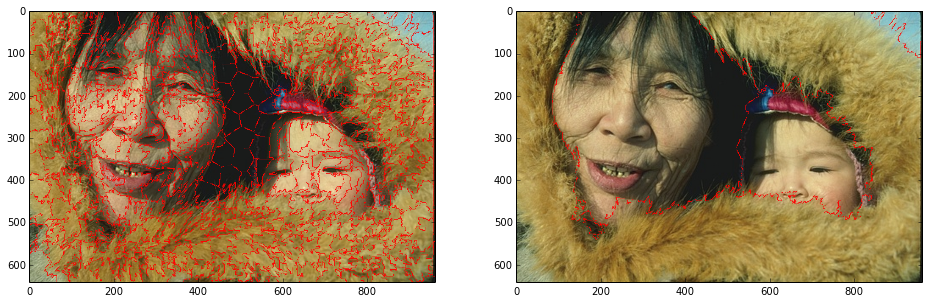

In [6]:
i = 0

print 'Maximum Number of Edges in an image:', max([e.edgeNum for e in trainingRags])
print 'Minimum Number of Edges in an image:', min([e.edgeNum for e in trainingRags])
print 'Mean Number of Edges in an image:', np.mean([e.edgeNum for e in trainingRags])


f = pylab.figure(figsize=(16,16))
ax0 = f.add_subplot(121)
trainingRags[i].show(trainingImgs[i], edgeColor=(1,0,0), alpha=0.)

ax1 = f.add_subplot(122)
trainingRags[i].show(trainingImgs[i], edgeColor=(1,0,0), alpha=0., labels=gtLabels[i])

vigra.show()

In [7]:
trainingFeatureSpaces = []
trainingEdges = []
t1 = time.time()
T = len(trainingImgs)
for i, (rag, img, trainId) in enumerate(zip(trainingRags, trainingImgs, trainingIds)):
    trainingEdges.append(rag.uvIds().astype('uint64'))

    features, trainingFeatureNames = getFeatures(rag, img, trainId)
    
    sys.stdout.write('\r')
    sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
    sys.stdout.flush()
    
    trainingFeatureSpaces.append(features)
t2 = time.time()

print "\nTime to built up Feature Space:", t2-t1, "sec"


[==================================================] 100%
Time to built up Feature Space: 390.788496971 sec


In [68]:
# Null Feature Vector für VOI ohne RF
#trainingFeatureSpaces[:] = [np.concatenate((featureSpace, np.zeros((featureSpace.shape[0], 1))), axis=1) for featureSpace in trainingFeatureSpaces]

In [65]:
RF = buildRandomForest(trainingFeatureSpaces, gtSols)

In [66]:
trainingRfProbs = getProbsFromRF(trainingFeatureSpaces, RF)

trainingFeatureSpaces[:] = [np.concatenate((featureSpace, prob), axis=1) for featureSpace, prob in zip(trainingFeatureSpaces, trainingRfProbs)]
trainingFeatureNames.extend(('RF_Prob1', 'RF_Prob2'))

In [8]:


weightVector = performLearning(trainingFeatureSpaces, trainingRags, trainingEdges, gtLabels, loss='partitionHamming')
#weightVector = performLearning(trainingFeatureSpaces, trainingRags, trainingEdges, gtLabels, loss='variationOfInformation')

Begin weight learning...
Learning Duration:  392.621798038 sec


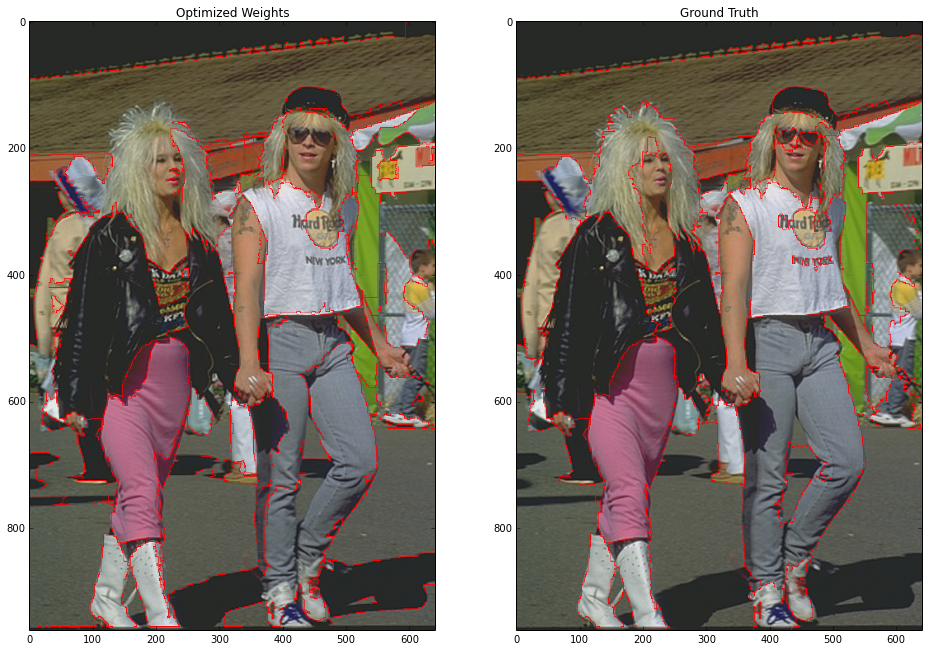

In [9]:
ParaMcModel = inferno.models.ParametrizedMulticutModel

nTrainSamples = len(trainingImgs)

modelVec = ParaMcModel.modelVector(nTrainSamples)

for n in range(nTrainSamples):

    nVar = trainingRags[n].nodeNum
    modelVec[n]._assign(nVar, trainingEdges[n]-1, trainingFeatureSpaces[n], weightVector) # -1 at edges so that nodes start at 0


############ Use Multicut on training image with given weightVector ###############
i = 10

if (i >= nTrainSamples or i < 0):
    print "i invalid! i was set to 0 for now!"
    i = 0

solver = inferno.inference.multicut(modelVec[i])

visitor = inferno.inference.verboseVisitor(modelVec[i])
solver.infer(visitor.visitor())

conf = solver.conf()

arg = conf.view().astype('uint32')
arg = np.array([0] + list(arg), dtype=np.uint32) + 1

f = pylab.figure(figsize=(16,16))
ax0 = f.add_subplot(1,2,1)
trainingRags[i].show(trainingImgs[i], labels=arg, edgeColor=(1,0,0), alpha=0.)
ax0.set_title('Optimized Weights')

ax1 = f.add_subplot(1,2,2)
trainingRags[i].show(trainingImgs[i], labels=gtLabels[i], edgeColor=(1,0,0), alpha=0.)
ax1.set_title('Ground Truth')


pylab.show()

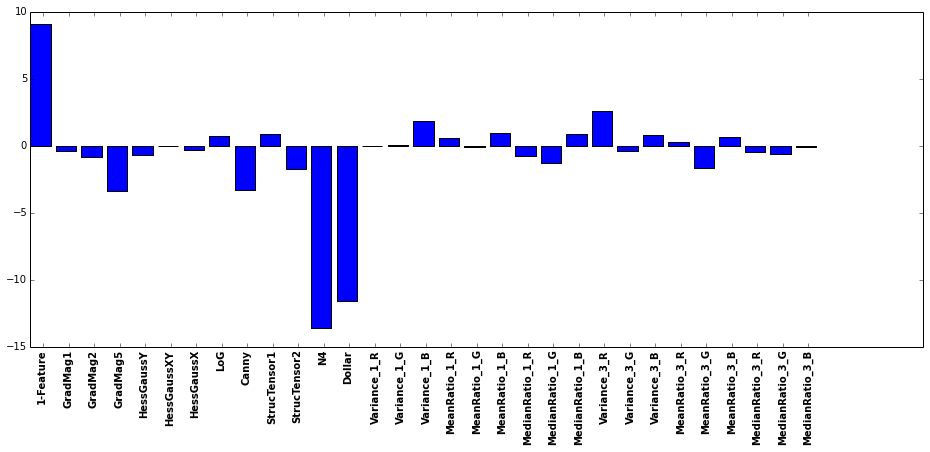

array([  9.11415385e+00,  -3.74576643e-01,  -8.53632504e-01,
        -3.36907700e+00,  -6.77204169e-01,  -5.58874785e-02,
        -3.43703796e-01,   7.32862066e-01,  -3.31395383e+00,
         8.40859594e-01,  -1.72708302e+00,  -1.36128153e+01,
        -1.16215981e+01,   2.02594132e-03,   6.19702172e-02,
         1.82198188e+00,   5.82990469e-01,  -1.35200766e-01,
         9.80326523e-01,  -7.84762017e-01,  -1.27757027e+00,
         8.51267744e-01,   2.61251948e+00,  -3.83878366e-01,
         8.23661703e-01,   2.87137245e-01,  -1.67033624e+00,
         6.42190280e-01,  -5.09201464e-01,  -6.36025106e-01,
        -6.82799750e-02])

In [11]:
auxWeightVec = np.zeros(len(weightVector))
for w in range(len(weightVector)):
    auxWeightVec[w] = weightVector[w]

f = plt.figure(figsize=(16,6))
ax = f.add_subplot(111)

ax.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax.set_xticks(np.linspace(0.5, len(trainingFeatureNames)-0.5, len(trainingFeatureNames)))
ax.set_xticklabels(trainingFeatureNames, rotation=90, weight=550)
plt.show()

auxWeightVec

# Testing

In [12]:
########### Use previous calculated weights ########################################

'''### partition Hamming without edgeLengthWeighted N4/Dollar
weights = np.array([  7.22419899,   0.40247906,  -0.32125476,  -2.90153402,
    -0.51362044,   0.10224229,   0.2178948 ,   0.50556576,
    -2.55662064,   1.4081388 ,  -1.8826377 , -12.43351795,
    -10.56668765,  -0.11710111,  -0.29926287,  -1.29157775,
    0.71614733,   0.61672725,  -0.77740122,  -0.77069566,
     0.75244262,  -0.23765505,   1.63286551,   2.07582006,
    0.572415  ,  -0.04897844,  -0.07422355,  -1.07454004,
    -0.38744577,  -0.37478441,  -0.75440215])




weightVector = inferno.learning.WeightVector(weights.shape[0], 0.0)

for i in range(len(weightVector)):
    weightVector[i] = weights[i]
'''

-1

In [12]:
########### Work with learned Random Forest and weights on Test Set #################

testSetPath = 'testSet/'

path = os.walk(testSetPath)

testImgs = []
testImgsLab = []
testIds = []

############# load images and convert to LAB #############
for root, dirs, files in path:
    for filename in files:
        if (filename.endswith('.jpg')):
            fileId = filename[:-4]
            testIds.append(fileId)
            testImgs.append(vigra.impex.readImage(root + filename))
            testImgsLab.append(vigra.colors.transform_RGB2Lab(testImgs[-1]))            


gridGraphs = []
testingRags = []
labelsList = []

############# get super-pixels with slic on LAB image and create regionAdjacencyGraph #############
superpixelDiameter = 20       # super-pixel size
slicWeight         = 25.0     # SLIC color - spatial weight
beta               = 0.5     # node vs edge weight
nodeNumStop        = 50         # desired num. nodes in result
minSize            = 15

for img in testImgs:            
            
    gridGraph = graphs.gridGraph(img.shape[0:2])
    gridGraphs.append(gridGraph)

    labelsList.append(vigra.analysis.slicSuperpixels(img, slicWeight, superpixelDiameter)[0])
    labelsList[-1] = vigra.analysis.labelImage(labelsList[-1])

    testingRags.append(graphs.regionAdjacencyGraph(gridGraphs[-1], labelsList[-1]))

del testImgsLab        # wird nur für SLIC gebraucht
del labelsList         # ist in rag gespeichert

In [13]:
TestingFeatureSpaces = []
TestingEdges = []
for rag, img, trainId in zip(testingRags, testImgs, testIds):
    TestingEdges.append(rag.uvIds().astype('uint64'))

    features = getFeatures(rag, img, trainId)[0]
    print "Feature Vector built!"
    sys.stdout.flush()

    TestingFeatureSpaces.append(features)

Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!


In [18]:
probs = getProbsFromRF(TestingFeatureSpaces, RF)

TestingFeatureSpaces[:] = [np.concatenate((featureSpace, prob), axis=1) for featureSpace, prob in zip(TestingFeatureSpaces, probs)]

NameError: name 'RF' is not defined

In [14]:
### build model

ParaMcModel = inferno.models.ParametrizedMulticutModel

nTestSamples = len(testImgs)
nFeatures = TestingFeatureSpaces[0].shape[1]

modelVec = ParaMcModel.modelVector(nTestSamples)

for n in range(nTestSamples):
    nVar = testingRags[n].nodeNum
    modelVec[n]._assign(nVar, TestingEdges[n]-1, TestingFeatureSpaces[n], weightVector)


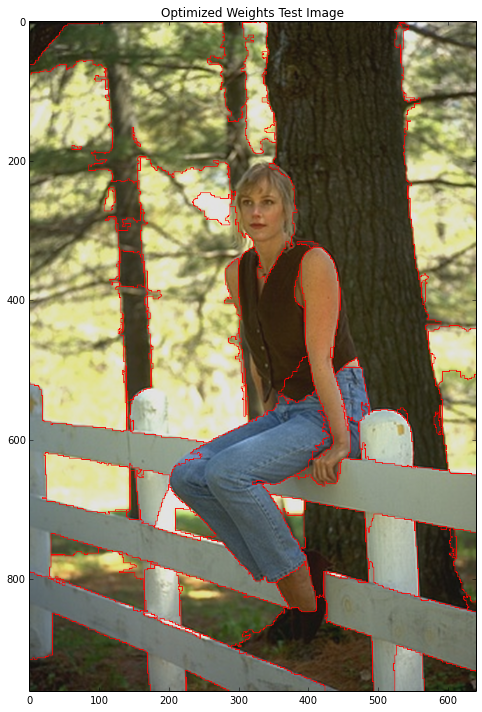

In [25]:
### solve
i = 7
if (i >= nTestSamples):
    print " i ungueltig!!!"
    sys.stdout.flush()
    i = 0

solver = inferno.inference.multicut(modelVec[i])

visitor = inferno.inference.verboseVisitor(modelVec[i])
solver.infer(visitor.visitor())

conf = solver.conf()

arg = conf.view().astype('uint32')
arg = np.array([0] + list(arg), dtype=np.uint32) + 1

f = pylab.figure(figsize=(12,12))
ax0 = f.add_subplot(111)
testingRags[i].show(testImgs[i], labels=arg, edgeColor=(1,0,0), alpha=0.)
ax0.set_title('Optimized Weights Test Image')

f.savefig('results/partitionHamming/imgLabFeatures/' + str(testIds[i]) + '.png')
#f.savefig('results/partitionHamming/' + str(testIds[i]) + '.png')
#f.savefig('results/variationOfInformation/edgeLengthWeighted_N4_Dollar/' + str(testIds[i]) + '.png')

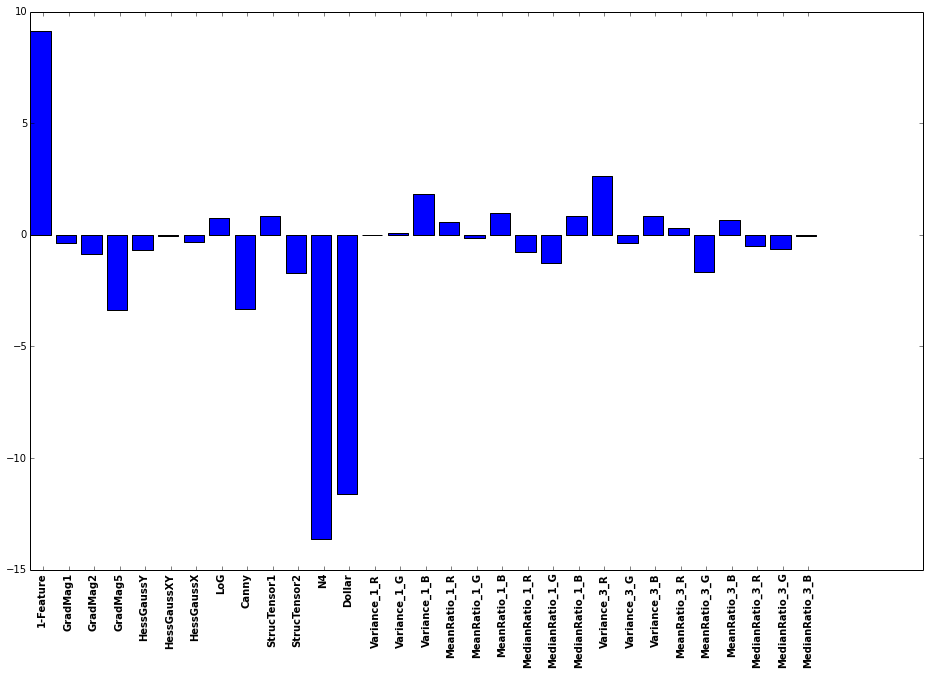

In [24]:
f = pylab.figure(figsize=(16,10))
ax1 = f.add_subplot(111)
ax1.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax1.set_xticks(np.linspace(0.5, len(trainingFeatureNames)-0.5, len(trainingFeatureNames)))
ax1.set_xticklabels(trainingFeatureNames, rotation=90, weight=550)

f.savefig('results/partitionHamming/imgLabFeatures/weights.png')

In [43]:
a = np.array(['a', 'b'])

np.where(a=='a')

(array([0]),)

1

In [13]:
rag = trainingRags[0]

print rag.edgeNum
print rag.edgeLengths().shape

2332
(2332,)


In [52]:
print "\n blubb \n"


 blubb 



In [40]:
plt.savefig?